This notebook includes the source code prepared for COMP5393-Capstone Project.
Project Title: Automated IELTS Essay Scoring by Using Machine Learning Algorithms
Project Author: Ekrem Bakay
Project Advisor: Dr. Mustafa Duran


# IELTS Predictor

IELTS is an international assessment tool which tests the ability to listen, read, write and speak in English and is graded on a scale of 1-9. While preparing to the exam, students usually take practice exams in which they can master their language skills. Unlike the IELTS reading and listening part, evaluating the IELTS writing task is time-consuming and also it needs an expert teacher which costs lots of money. With Artificial Intelligence, Machine Learning and Natural Language Processing it is now possible to get instant IELTS writing evaluation. This project will automate the evaluation and scoring of an IELTS practice essay by using machine learning models.

## 1-Importing Necessary Libraries
In the first step, I always import all the necessary python libraries in the first cell. Below cell imports all the libraries used in this notebook.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random
import gc
import os
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

Let's set the seed of the random number generator to a fixed value, so that when it is called, the results will be reproducible.

In [3]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

______
______

## 2- Data Preparation
### 2.1- Creating the Dataseet
After finding 204 pdf documents which provides three different rater scores for various task 2 essay texts, I converted each pdf to a txt file which includes essay topic, essay body and three scores separated by # sign. Each txt file was then processed and collected as a dataset by a python code and saved as csv file which will be used in further steps. Below cells include the python code which converts txt file to pandas dataframe and saves it as csv.

In [4]:
# function to convert each txt file to a dictionary object
def load_files():
    new_dic = {}
    Topic, Essay, S1, S2, S3 = [], [] , [], [], []
    file_path = os.path.join(os.getcwd(), "essays/")
    for file in os.listdir(file_path):
        extension = os.path.splitext(file)[1]
        if extension == ".txt":
            with open(os.path.join(file_path, file)) as f:
                index = 0
                essay_line = ""
                for line in f:
                    if line.strip()=='#':
                        index += 1
                        continue
                    if index == 0:
                        Topic.append(line.strip())
                    elif index == 1:
                        essay_line = essay_line + " " + line.strip()
                    elif index == 2:
                        S1.append(float(line.rstrip()))
                    elif index == 3:
                        S2.append(float(line.rstrip()))
                    else:
                        S3.append(float(line.rstrip()))
                Essay.append(essay_line)
        new_dic = {'EssayTopic': Topic, 'EssayBody': Essay, 'S1': S1, 'S2': S2, 'S3': S3}
    return new_dic

In [5]:
# use load_files function to get the txt file content as dictionary object and convert it to pandas dataframe
df = pd.DataFrame.from_dict(load_files())

# calculate average essay score by combining three rater scores
df['EssayScore'] = np.round(((df["S1"] + df["S2"] + df["S3"])/3)*2)/2

# save the dataframe as csv file to be used in further processing
df.to_csv("essay_dataset.csv", index=False)

### 2.2 Importing data
In the next step, created csv file is imported to be used in the remaining of this notebook. Pandas libraries will be used to import the csv data and process it as a dataframe named 'essays'. After importing, values are sorted according to 'EssayScore' column which hold the target essay score. Below cell executes the code for import process, and output shows a part of the dataframe created.

In [6]:
essays = pd.read_csv('essay_dataset.csv')
essays.sort_values(by=['EssayScore'], inplace=True)
essays.head()

,EssayTopic,EssayBody,S1,S2,S3,EssayScore
60,What kind of climate do you prefer to live in?...,"Human live in the earth, as result they have ...",5.0,5.5,5.0,5.0
55,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,5.0
31,It is possible to be single for all your life ...,As long as the world around us has become mod...,5.0,5.0,5.0,5.0
40,Money can solve all problems. Do you agree or ...,"These days, people’s life is more complex, ha...",5.0,5.0,5.0,5.0
10,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,5.0


### 2.3 Exploratory Data Analysis
Let's check the data type for each column and whether there is any missing data. As it can be seen from the output, EssayTopic and EssayBody columns have the "object" type and all the other column have "float" data type. None of the columns has missing value.

In [7]:
# print data types and number of null values for each column
print(essays.dtypes)
print('\n')
print(essays.isnull().sum())

EssayTopic     object
EssayBody      object
S1            float64
S2            float64
S3            float64
EssayScore    float64
dtype: object


EssayTopic    0
EssayBody     0
S1            0
S2            0
S3            0
EssayScore    0
dtype: int64


Pandas’s describe function gives an overview about numeric features of the data which is presented in the below table. According to table, the data contains 68 rows of values. The minimum value for essay scores is five, while the maximum value is nine.

In [8]:
# Describe the statistics for numeric columns
essays.describe()

,S1,S2,S3,EssayScore
count,68.000000,68.000000,68.000000,68.000000
mean,7.470588,7.551471,7.477941,7.522059
std,1.218276,1.149756,1.107754,1.144206
min,5.000000,5.000000,5.000000,5.000000
25%,6.500000,6.500000,6.875000,6.500000
50%,8.000000,8.000000,8.000000,8.000000
75%,8.500000,8.500000,8.500000,8.500000
max,9.000000,9.000000,9.000000,9.000000


Although IELTS band scores are between 1 and 9, our dataset includes scores from 5 till 9 incremented by 0.5. Below chart shows the distribution of unique scores according to their number of occurrences in the dataset. Each score occurs in the following frequencies; 5: 5 times, 5.5: 1 time, 6: 4 times, 6.5: 8 times, 7: 6 times, 7.5: 7 times, 8: 14 times, 8.5: 17 times, 9: 6 times.

As it can be seen from the above chart that the data distribution is unbalanced. Thus, it should be organized in way that it will produce results without bias. In order to reduce to complexity of the analysis and provide balance for the dataset, the closer scores will be grouped under three main classes such that; low band: scores between 5 and 6.5, moderate band: scores between 7 and 8, and high band: scores above 8.

<AxesSubplot:>

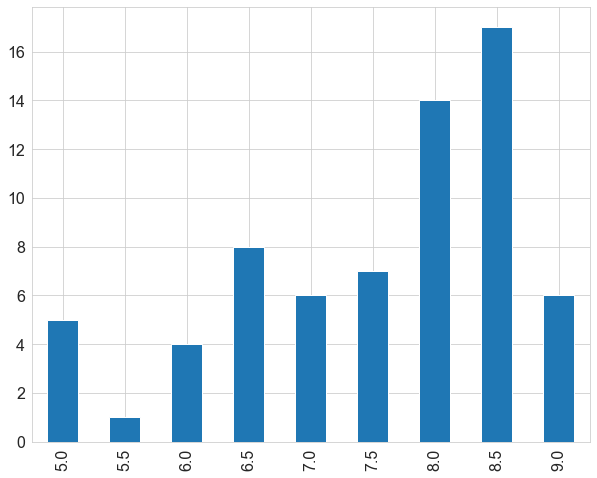

In [9]:
# plot the unique value counts for the EssayScore column which holds the target data.
essays['EssayScore'].value_counts().sort_index().plot(kind='bar', figsize=(10,8), fontsize=16)

Another property that is going to be explored is the sequence length, i.e. word count, in each essay. Later in data preprocessing step, it will be used to determine the maximum length for data tokenization. Below chart shows the frequency of the word counts for all the essay data. The yellow line represents the mean value of the word counts which is almost 300 words in average.

In [10]:
# get the word counts in each essay body.
seqlen = essays['EssayBody'].apply(lambda x: len(x.split()))

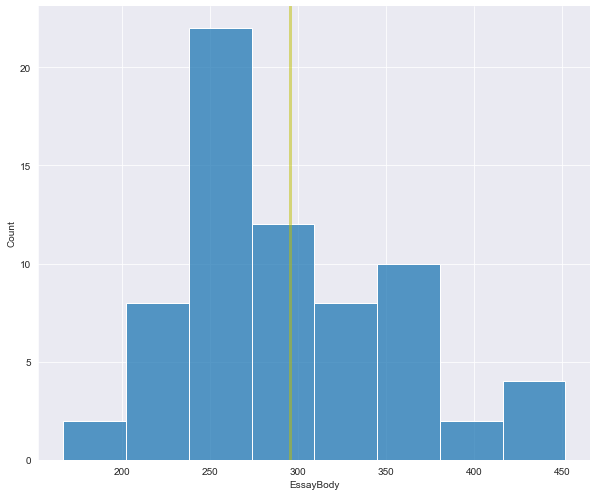

In [11]:
# plot the word count frequencies for each word count range
sns.set_style('darkgrid')
sns.displot(seqlen, height=7, aspect=1.2)
plt.axvline(x=seqlen.mean(), linewidth=3, color='y', label="mean", alpha=0.5)

### 2.4-Data Preprocessing
#### 2.4.1 Encoding Score Data
In order to simplify data processing and improve the classification accuracy, the target data (essay scores) need to be grouped according to the score range. Below cell includes a function that checks for each essay and replaces the score value accordingly.

In [12]:
# function to relabel essay score data
def new_label(value):
    if value > 8:
        return 'High Band'
    elif value > 7:
        return 'Moderate Band'
    else:
        return 'Low Band'

Let's apply above function to EssayScore column to change the label values.

In [13]:
# apply new_label function
essays['EssayScore'] = essays['EssayScore'].map(new_label)
essays.head()

,EssayTopic,EssayBody,S1,S2,S3,EssayScore
60,What kind of climate do you prefer to live in?...,"Human live in the earth, as result they have ...",5.0,5.5,5.0,Low Band
55,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,Low Band
31,It is possible to be single for all your life ...,As long as the world around us has become mod...,5.0,5.0,5.0,Low Band
40,Money can solve all problems. Do you agree or ...,"These days, people’s life is more complex, ha...",5.0,5.0,5.0,Low Band
10,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,Low Band


After executing the code, distribution of the new scores values and their frequencies will be printed by using the below code and chart.

Low Band         24
High Band        23
Moderate Band    21
Name: EssayScore, dtype: int64


<AxesSubplot:>

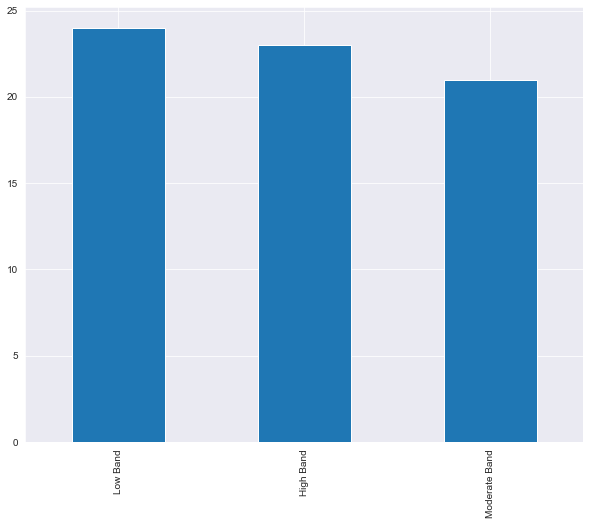

In [14]:
# print the new value counts for new essay score labels and plot them to a bar chart
print(essays['EssayScore'].value_counts())
essays['EssayScore'].value_counts().plot(kind='bar', figsize=(10,8))

Computers are better understanding the number, so the string class values for essay scores need to be encoded as numbers. In order to do that, a new python dictionary is created according to unique values of essay scores and this dictionary is used to replace the string score values as numerical score values. Then, column data type is converted to integer to ensure that the data is numerical and ready to be used in the machine learning model.

In [15]:
# create a python dictionary to hold the unique values of target data. this dictionary will be used to encode the labels
possible_labels = essays.EssayScore.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Low Band': 0, 'Moderate Band': 1, 'High Band': 2}

In [16]:
# encode the score data by using the label dictionary
essays['EssayScore'] = essays.EssayScore.replace(label_dict)
essays = essays.astype({'EssayScore': int})

#### 2.4.2 Named Entity Recognition
Named entity recognition (NER) helps to easily identify the key elements in a text, like names of people, places, brands, monetary values, and more. Extracting the main entities in a text helps sort unstructured data and detect important information, which is crucial when it requires to deal with large datasets.

Following two cells finds named entities in the essay text and replaces them with their corresponding NER labels.

In [17]:
# load spycy for named entity recognition
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities")

# create the function for named entity recognition
def ner_tag(text):
    doc = nlp(text)
    new_text = (" ".join([t.text if not t.ent_type_ else '@' + t.ent_type_ for t in doc])).strip()
    return new_text

In [18]:
# apply named entity recognition to the essay text.
essays['EssayBody'] = essays['EssayBody'].map(ner_tag)

______
______

## 3-Model Building
### 3.1-Split Train-Test Data
To be able to train the model, the dataset must be divided as train and test data set. The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model. It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms for the predictive modeling problem.

 Because in our dataset the labels are imbalanced, the dataset will be split in a stratified fashion, by using unique values of the target data. Thus, each label will have a balanced train and test data according to the proportion of the number of values. Below cell executes the code which splits the data into train and test data sets.


In [19]:
# Split data to train-test dataset. Data will be split according to number of occurrences of each unique score.
X_train, X_val, y_train, y_val = train_test_split(essays.index.values, 
                                                  essays.EssayScore.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=essays.EssayScore.values)

essays['data_type'] = ['not_set']*essays.shape[0]

essays.loc[X_train, 'data_type'] = 'train'
essays.loc[X_val, 'data_type'] = 'val'

# show the train-test dataset counts for each score value
essays.groupby(['EssayScore', 'data_type']).count()

EssayTopic  EssayBody  S1  S2  S3
EssayScore data_type                                   
0          train              19         19  19  19  19
           val                 5          5   5   5   5
1          train              17         17  17  17  17
           val                 4          4   4   4   4
2          train              18         18  18  18  18
           val                 5          5   5   5   5

### 3.2-Tokenize the Essay Text
Tokenization is a way of separating a piece of text into smaller units called tokens. These tokens help in understanding the context or developing the model for the NLP. The tokenization helps in interpreting the meaning of the text by analyzing the sequence of the words.

For our model, we will be implementing BERT tokenizer which uses what is called a WordPiece tokenizer. It works by splitting words either into the full forms (e.g., one word becomes one token) or into word pieces— where one word can be broken into multiple tokens.

A pre-trained BERT model configuration must be initialized in order to encode the data. To convert all the essays from text into encoded form, a function called batch_encode_plus is used. Also train and validation data will be tokenized separately. Below code tokenizes all the data.


In [20]:
# get the pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# get the tokens for train data
encoded_data_train = tokenizer.batch_encode_plus(
    essays[essays.data_type=='train'].EssayBody.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length = 318,
    truncation=True,
    return_tensors='pt'
)

# get the tokens for test data
encoded_data_val = tokenizer.batch_encode_plus(
    essays[essays.data_type=='val'].EssayBody.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length = 318,
    truncation=True,
    return_tensors='pt'
)

# get input_ids, attention mask, and labels for train data
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(essays[essays.data_type=='train'].EssayScore.values)

# get input_ids, attention mask, and labels for test data
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(essays[essays.data_type=='val'].EssayScore.values)

# form train and test data from encoded data with tensors
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

After getting the tokenized data, it needs to be split into input_ids, attention_masks and labels. Input IDs are simply mappings between tokens and their respective IDs. The attention mask is to prevent the model from looking at padding tokens. Finally, encoded training dataset and test dataset is extracted from tokenized data. Now the data is ready to be used in the model building process.

### 3.3-Model Building
#### 3.3.1 Model Selection
For this project, data will be trained by using BERT - Bidirectional Encoder Representations from Transformers- which is a transformer-based machine learning technique for natural language processing (NLP) developed by Google. BERT was pre-trained on unsupervised Wikipedia and Bookcorpus datasets using language modeling.

Two types of BERT models are introduced- BERTBase and BERTLarge – according to the depth of the model architecture. The BERTBase model uses 12 layers of transformers block with a hidden size of 768 and number of self-attention heads as 12 and has around 110M trainable parameters. On the other hand, BERTLarge uses 24 layers of transformers block with a hidden size of 1024 and number of self-attention heads as 16 and has around 340M trainable parameters.


For the implementation of BERT for any task on our dataset, pre-trained weights are available and these pre-trained weights will be used to fine-tune the model on our own dataset. Each essay text is being treated as its unique sequence, so one sequence will be classified to one of the three labels (i.e. Low, moderate or high band). From the BERT model library, BertForSequenceClassification model is used with the following parameters
•	bert-base-uncased: as the pretrained weights which is a lightweight model.
•	Using num_labels equal to length of label dictionary which indicates the number of output labels.
•	output_attentions and output_hidden_states are set to false since they are not really required.


In [21]:
# model selection: BERT sequence classifier model is used with pretrained weights.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### 3.3.2 Creating the Data Loaders
PyTorch’s DataLoader is a useful feature that keeps the data organized and simplifies our machine learning pipeline. It allows us to iterate the data, manage batches, and shuffle the samples to avoid overfitting. In this project, we used RandomSampler for training and SequentialSampler for validation.

The batch size refers to how many training instances are employed in a single iteration. This is usually used when the number of training instances is quite large, and it is usually effective to divide the entire data into small batches. Minimum number for batch size is 1. As the batch size increases, so the memory usage increases too. Thus, in case there is limited memory available, the batch size should be kept minimum.


In [43]:
# create the dataloaders with a batch size of 1
batch_size = 1

# create train dataloader with random sampler
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

# create validation dataloader with sequential sampler
dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

#### 3.3.3 Optimizer and Scheduler Selection
For this project, Pytorch’s AdamW optimizer with a scheduler is used to optimize the learning process. The adam optimizer has several benefits such as it is straightforward to implement, has faster running time, low memory requirements, and requires less tuning than any other optimization algorithm.

As the scheduler, get_linear_schedule_with_warmup from the transformers library is used to create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

In [18]:
# select AdamW optimizer for optimization job
optimizer = AdamW(model.parameters(),
                  lr=3e-5, 
                  eps=1e-8)
# set the number of epochs
epochs = 5

# set the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### 3.3.4 Creating Accuracy Functions with Metrics
For this project, F1 score has been used as a model performance metric. The F-score or F-measure is a measure of a test's accuracy. It is calculated from the precision and recall of the test, where the precision is the number of true positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of true positive results divided by the number of all samples that should have been identified as positive.

The F1 score becomes especially valuable when working on classification models in which the data set is imbalanced. Additionally, the F1 score works much better in estimating the performance of a machine learning model.

Moreover, accuracy of each class is calculated by getting the number of true values and true predictions. This is done by the accuracy_per_class function. We will use this function after training and saving the model to see the accuracy of saved model.

In [22]:
# this function calculates the F1 score
def calculate_f1_score(predicted, labels):
    predictions_flat = np.argmax(predicted, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, predictions_flat, average='weighted')

# this function calculates the accuracy of each class by getting the correct predictions
def accuracy_per_class(predicted, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    predictions_flat = np.argmax(predicted, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_predictions = predictions_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_predictions[y_predictions==label])}/{len(y_true)}\n')

In [23]:
# set the device to CUDA if GPU is available for fast processing, otherwise us CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


#### 3.3.5 Evaluation Function
Before starting to train the model, we will create the evaluation function which will perform predictions and validations for the model training and model evaluation. This functions includes an input parameter which holds the dataloader values for validation data. After execution, evaluation function returns three variables that keeps the results for average loss value, predicted values, and true values from test dataset.

In [19]:
def evaluate(dataloader_val):
    # switch model to evaluation mode
    model.eval()

    # define variables to hold predictions, loss and true values
    loss_val_total = 0
    predictions, true_vals = [], []

    # Start predictions for each data in dataloader
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    # calculate averge loss value
    loss_val_avg = loss_val_total/len(dataloader_val) 

    # list predictions and true values
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    # return all the results
    return loss_val_avg, predictions, true_vals

In [7]:
# This function clears the cash in case there is not any available memory for cuda device
gc.collect()
torch.cuda.empty_cache()

#### 3.3.6 Model Training
In the final step, we are ready to train our model by combining all the parameters created so far. Model is switched to training mode and fed by the training data which includes input ids, attention mask and the labels. A better visual representation is provided by adding the tqdm library and the progress bar. There are two loops; outer loop provides iterations for each epoch and inner loop provides iteration for training. At the end of each epoch, training loss, validation loss, and f1 score is calculated and the model is saved to a folder. The best model trained then will be used for evaluation purposes.

In [24]:
# first loop to start iterate through each epoch
for epoch in tqdm(range(1, epochs+1)):
    #switch model to training mode
    model.train()
    
    loss_train_total = 0
    #start training the model
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    # save model for future use
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    # calculate training loss
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    # calculate validation loss and f1 score
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = calculate_f1_score(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.1003459416053913
Validation loss: 1.0911068235124861
F1 Score (Weighted): 0.3174603174603175


Epoch 2:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.0030735394469015
Validation loss: 0.8250943379742759
F1 Score (Weighted): 0.4693877551020408


Epoch 3:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9710028397816198
Validation loss: 0.6448051386645862
F1 Score (Weighted): 0.8398268398268397


Epoch 4:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7429846806658639
Validation loss: 0.5844805517366954
F1 Score (Weighted): 0.7736549165120594


Epoch 5:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.647342998534441
Validation loss: 0.6297583042510918
F1 Score (Weighted): 0.7142857142857144


#### 3.3.7 Accuracy Per Class
After completing the training phase, the best model with the best f1 score is used for calculating the accuracy of each class. By using load_state_dict method of the model, first we load our saved model and then make predictions according to the test data. Finally, accuracy_per_class function was called to print the accuracy of each label value.

In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('model.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Band-6
Accuracy: 5/5

Class: Band-7
Accuracy: 2/4

Class: Band-8
Accuracy: 5/5

